<a href="https://colab.research.google.com/github/gfi1ippou/Robyn/blob/main/4th_publication_python_MCVSBART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Marvov Chain MTA Vs BART

TL;DR: We test our hypothesis for a potential publication. Our aim is to prove that ML and more specifically BART is able to offer better data-driven results for MTA.

Markov Chain used by many companies as data-driven attribution model.

For instance:

1.   Atherton, R. and Hogben, L., 2005. A Look at Markov Chains and Their Use in Google. Iowa State University, MSM Creative Component.

2.   Kakalejčík, L., Bucko, J., Resende, P.A. and Ferencova, M., 2018. Multichannel marketing attribution using Markov chains. Journal of Applied Management and Investments, 7(1), pp.49-60.

3. Kakalejčík, L., Bucko, J. and Resende, P.A., 2021. Multichannel Marketing Attribution Using Markov Chains for E-Commerce. Statistika: Statistics & Economy Journal, 101(2).


Now, we want to experiment if another algorithm is able to generate better results.

Therefore we use BART

Chipman, H.A., George, E.I. and McCulloch, R.E., 2010. BART: Bayesian additive regression trees.


BART has never been used for attribution in the past.


---



---

In [ ]:
%%capture
!pip install --upgrade pip
!pip install ChannelAttribution

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import plotly.express as px

from ChannelAttribution import *
import plotly.io as pio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename));


Import Data

In [ ]:
#Importing the drive (Kaggle data set)
path="/content/drive/MyDrive/Publications /4th Publication/Data/3rd-party-kaggle data/attribution data (1).csv"
df=pd.read_csv(path)
df['time'] = pd.to_datetime(df['time'])
df.head(5)

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search


In [ ]:
#Plotting conversions over time by channel
conversions = df.loc[df['conversion'] == 1]
conversions['time'] = conversions['time'].dt.date
conversions = conversions[conversions['time']< pd.to_datetime("2018-7-30").date()]
conversions.drop(columns = ['cookie', 'interaction'], inplace = True)
conversions = conversions.groupby(['time','channel'], as_index=False).sum()

fig = px.line(conversions, x='time', y='conversion', color='channel')

fig.update_layout(title='Channel Conversions over Time',
                   xaxis_title='Conversions',
                   yaxis_title='Date')
fig.show()


In [ ]:
#Creating the path order for when users interact with different channels (this is equivalent to SQL window functions)
df['path_order'] = df.sort_values(['time']).groupby(['cookie']).cumcount() + 1
df.head()


,cookie,time,interaction,conversion,conversion_value,channel,path_order
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,1
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,2
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,3
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,4
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search,1


In [ ]:
df_paths = df.groupby('cookie')['channel'].agg(lambda x: x.tolist()).reset_index()
df_paths = df_paths.rename(columns={"channel": "path"})
df_paths.head()


,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On..."
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S..."
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S..."
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]


In [ ]:
#Looking at the last interaction to see if it led to a user converting
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion', 'conversion_value']]
df_last_interaction.head()

,cookie,conversion,conversion_value
3,00000FkCnDfDDf0iC97iC703B,0,0.0
9,0000nACkD9nFkBBDECD3ki00E,0,0.0
14,0003EfE37E93D0BC03iBhBBhF,0,0.0
15,00073CFE3FoFCn70fBhB3kfon,0,0.0
16,00079hhBkDF3k3kDkiFi9EFAD,0,0.0


In [ ]:
#Concatinating with the dataframes of user path's
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.head()

,cookie,path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On...",0,0.0
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,0.0


In [ ]:
print('Total conversions: {}'.format(sum(df.conversion)))
print('Total conversion rate: {}%'.format(round(sum(df.conversion) / len(df)*100)))
print('Total value of conversions: ${}'.format(round(sum(df.conversion_value))))
print('Average conversion value: ${}'.format(round(sum(df.conversion_value) / sum(df.conversion))))


Total conversions: 17639
Total conversion rate: 3%
Total value of conversions: $110231
Average conversion value: $6


In [ ]:
#We will create a variable ‘path’ in the specific formatrequired by the Attribution Model where the ordered channels a user interacts with are delimited by'>'
def listToString(df):
    str1 = ""
    for i in df['path']:
        str1 += i + ' > '
    return str1[:-3]

df_paths['path'] = df_paths.apply(listToString, axis=1)
df_paths.head()


,cookie,path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,Instagram > Online Display > Online Display > ...,0,0.0
1,0000nACkD9nFkBBDECD3ki00E,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
2,0003EfE37E93D0BC03iBhBBhF,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
3,00073CFE3FoFCn70fBhB3kfon,Instagram,0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,Paid Search,0,0.0


In [ ]:
#Removing the user's cookie and grouping by the path to see the how many times a specific combination of channels led to a conversion or null outcome
df_paths.drop(columns = 'cookie', inplace = True)
df_paths['null'] = np.where(df_paths['conversion'] == 0,1,0)

attribution_df = df_paths.groupby(['path'], as_index = False).sum()
attribution_df.rename(columns={"conversion": "total_conversions", "null": "total_null", "conversion_value": "total_conversion_value"}, inplace = True)
attribution_df.sample(10)


,path,total_conversions,total_conversion_value,total_null
4193,Instagram > Facebook > Facebook > Facebook > F...,1,7.0,1
5009,Instagram > Facebook > Online Video > Instagram,0,0.0,1
444,Facebook > Facebook > Facebook > Facebook > In...,1,5.0,0
3556,Facebook > Online Video > Online Video > Onlin...,1,6.5,0
9864,Paid Search > Online Display > Online Display ...,0,0.0,1
1324,Facebook > Facebook > Instagram > Facebook > F...,2,14.5,38
49,Facebook > Facebook > Facebook > Facebook > Fa...,0,0.0,2
6500,Online Display > Instagram > Paid Search > Pai...,0,0.0,1
8374,Online Video > Online Video > Online Video > O...,1,7.5,0
544,Facebook > Facebook > Facebook > Facebook > In...,0,0.0,3


In [ ]:
#Now, we will use the ChannelAttribution package to create the attribution models described above

#Heuristic models
H=heuristic_models(attribution_df,"path","total_conversions",var_value="total_conversion_value")

#Markov Models
M=markov_model(attribution_df, "path", "total_conversions", var_value="total_conversion_value")


*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Number of simulations: 100000 - Convergence reached: 1.58% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (48) is reached: 99.99%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


In [ ]:
R=pd.merge(H,M,on="channel_name",how="inner")
R1=R[["channel_name","first_touch_conversions","last_touch_conversions",\
"linear_touch_conversions","total_conversions"]]
R1.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

R1=pd.melt(R1, id_vars="channel_name")

data = [dict(type = "histogram", histfunc="sum",x = R1.channel_name, y = R1.value,
             transforms = [dict(type = "groupby", groups = R1.variable,)],)]

fig = dict({"data":data})
pio.show(fig,validate=False)


In [ ]:
R2=R[["channel_name","first_touch_value","last_touch_value",\
"linear_touch_value","total_conversion_value"]]
R2.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

R2=pd.melt(R2, id_vars="channel_name")
data = [dict(type = "histogram", histfunc="sum", x = R2.channel_name, y = R2.value,
             transforms = [dict(type = "groupby",groups = R2.variable,)],)]

fig = dict({"data":data})
pio.show(fig,validate=False)


In [ ]:
transition_matrix = transition_matrix(attribution_df, "path", "total_conversions", var_null="total_null")


*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


In [ ]:
matrix = transition_matrix['transition_matrix']
matrix = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'],
                    columns=['channel_to'], aggfunc=np.sum)

column_dict = transition_matrix['channels'].set_index('id_channel')['channel_name'].to_dict()
keys_values = column_dict.items()
column_dict = {str(key): str(value) for key, value in keys_values}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace = True)

<ipython-input-18-ce9ba9d4219b>:2: FutureWarning:

The provided callable <function sum at 0x7aa24aec84a0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, '(conversion)'),
  Text(1.5, 0, '(null)'),
  Text(2.5, 0, 'Facebook'),
  Text(3.5, 0, 'Instagram'),
  Text(4.5, 0, 'Online Display'),
  Text(5.5, 0, 'Online Video'),
  Text(6.5, 0, 'Paid Search')])

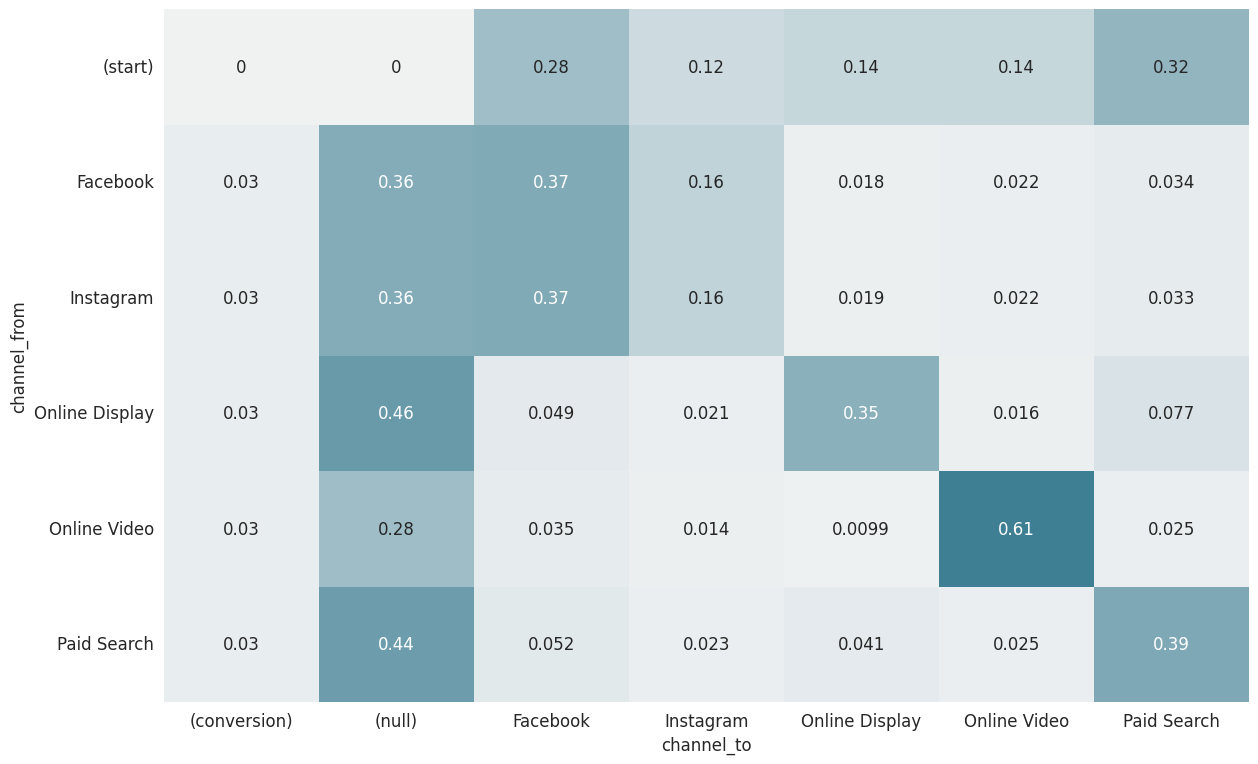

In [ ]:
#Heat map for transition probabilities in the data set
fig = plt.figure(figsize = (14,9))
style.use('ggplot')
sns.set_style('whitegrid')

sns.heatmap(matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, center = 0,\
            annot_kws={'size':12}, cbar=False)
plt.yticks(rotation=0, fontsize = 12)
plt.xticks(fontsize = 12)




---



---



---



---



# Markov Chain Attribution without cookie (kaggle data set)


# Results not reliable without Cookie information.

In [ ]:
# %%capture
!pip install --upgrade pip
!pip install ChannelAttribution

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import plotly.express as px
from ChannelAttribution import heuristic_models, markov_model, transition_matrix
import plotly.io as pio

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

ERROR: Operation cancelled by user
ERROR: Operation cancelled by user


In [ ]:
# List files (optional, as in the original code)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:

# ---------------------------
# Import Data
# ---------------------------
# In this version we assume that each row in the CSV is a complete journey.
# (In the original code, multiple interactions were aggregated using the cookie ID;
# here we simply ignore the cookie column so that our aggregation is done by journey.)
path = ""
df = pd.read_csv(path)

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])
df.head(5)



,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search


In [ ]:

# ---------------------------
# Plot Conversions Over Time by Channel
# ---------------------------
# (The cookie and interaction columns are dropped since they are not needed here.)
conversions = df.loc[df['conversion'] == 1].copy()
conversions['time'] = conversions['time'].dt.date
conversions = conversions[conversions['time'] < pd.to_datetime("2018-7-30").date()]
conversions.drop(columns=['Cookie', 'interaction'], inplace=True, errors='ignore')

conversions = conversions.groupby(['time', 'channel'], as_index=False).sum()

fig = px.line(conversions, x='time', y='conversion', color='channel')
fig.update_layout(title='Channel Conversions over Time',
                  xaxis_title='Time',
                  yaxis_title='Conversions')
fig.show()

In [ ]:

# ---------------------------
# Build Journey Paths without Cookie IDs
# ---------------------------
# In the original code, journeys were built by grouping on the cookie ID and then merging in
# each user’s last interaction (to get conversion and conversion value).
#
# Here we assume that each row in the data already represents a full journey.
# If a “path” column does not exist, we create one using the channel information.
if 'path' not in df.columns:
    # If your data is not pre-aggregated, then each row will simply be a one‐touch journey.
    # You can later adjust this step if you have another way of defining journeys.
    df['path'] = df['channel']

# (Optionally, if the cookie column exists, we drop it since we no longer use it.)
if 'Cookie' in df.columns:
    df.drop(columns='Cookie', inplace=True)

# Create a flag for non‐conversion (commonly called “null”)
df['null'] = np.where(df['conversion'] == 0, 1, 0)

# Group by the journey “path” so that if multiple journeys share the same sequence,
# we sum their conversion counts, null counts, and conversion values.
attribution_df = df.groupby(['path'], as_index=False).agg({
    'conversion': 'sum',
    'null': 'sum',
    'conversion_value': 'sum'
})
attribution_df.rename(columns={"conversion": "total_conversions",
                               "null": "total_null",
                               "conversion_value": "total_conversion_value"}, inplace=True)
sample_size = min(10, len(attribution_df))

print("Sample of aggregated journey data:")
print(attribution_df.sample(sample_size)) # Use the adjusted sample size



Sample of aggregated journey data:
             path  total_conversions  total_null  total_conversion_value
1       Instagram               2244       72957                 14039.5
4     Paid Search               4547      146893                 28331.5
0        Facebook               5301      170440                 33143.5
2  Online Display               2139       68914                 13298.5
3    Online Video               3408      109894                 21418.0


In [ ]:

# ---------------------------
# Run the Attribution Models from ChannelAttribution
# ---------------------------
# Heuristic models (first touch, last touch, linear)
H = heuristic_models(attribution_df, "path", "total_conversions", var_value="total_conversion_value")

# Markov model
M = markov_model(attribution_df, "path", "total_conversions", var_value="total_conversion_value")

# Merge the results for side-by-side comparison
R = pd.merge(H, M, on="channel_name", how="inner")

# Prepare conversion counts comparison
R1 = R[["channel_name", "first_touch_conversions", "last_touch_conversions",
        "linear_touch_conversions", "total_conversions"]].copy()
R1.columns = ["channel_name", "first_touch", "last_touch", "linear_touch", "markov_model"]

R1 = pd.melt(R1, id_vars="channel_name")
data = [dict(type="histogram", histfunc="sum", x=R1.channel_name, y=R1.value,
             transforms=[dict(type="groupby", groups=R1.variable)])]

fig = dict({"data": data})
pio.show(fig, validate=False)


*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Number of simulations: 100000 - Convergence reached: 2.69% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (2) is reached: 99.99%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


In [ ]:

# Prepare conversion value comparison
R2 = R[["channel_name", "first_touch_value", "last_touch_value",
        "linear_touch_value", "total_conversion_value"]].copy()
R2.columns = ["channel_name", "first_touch", "last_touch", "linear_touch", "markov_model"]

R2 = pd.melt(R2, id_vars="channel_name")
data = [dict(type="histogram", histfunc="sum", x=R2.channel_name, y=R2.value,
             transforms=[dict(type="groupby", groups=R2.variable)])]

fig = dict({"data": data})
pio.show(fig, validate=False)


*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


<ipython-input-11-9ab5e90a1179>:8: FutureWarning:

The provided callable <function sum at 0x7fa79b51c400> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



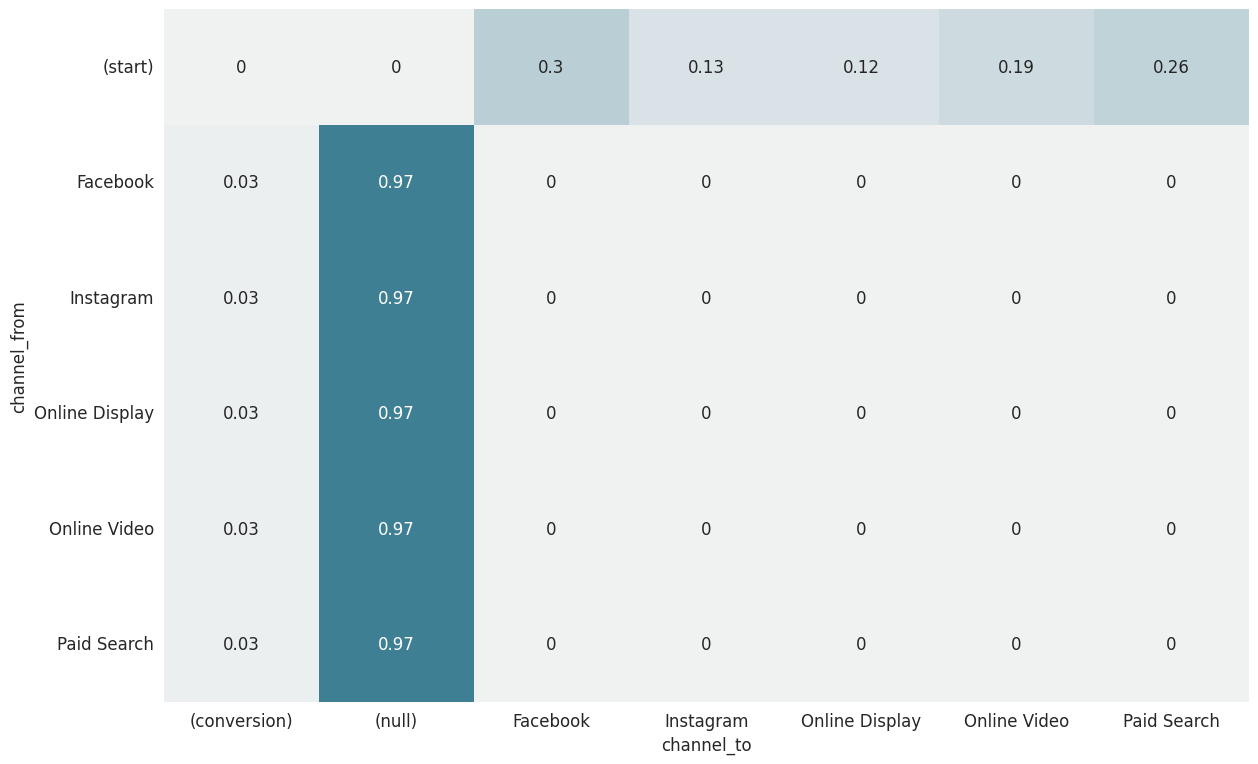

In [ ]:

# ---------------------------
# Build and Plot the Transition Matrix
# ---------------------------
tm = transition_matrix(attribution_df, "path", "total_conversions", var_null="total_null")

# Pivot the transition matrix for display
matrix = tm['transition_matrix']
matrix = pd.pivot_table(matrix, values='transition_probability',
                        index=['channel_from'], columns=['channel_to'], aggfunc=np.sum)

# Rename rows and columns using the channel mapping dictionary
column_dict = tm['channels'].set_index('id_channel')['channel_name'].to_dict()
column_dict = {str(key): str(value) for key, value in column_dict.items()}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace=True)

# Plot the heat map
plt.figure(figsize=(14,9))
style.use('ggplot')
sns.set_style('whitegrid')
sns.heatmap(matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, center=0,
            annot_kws={'size':12}, cbar=False)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12)
plt.show()

Conclucsion so far, we can't do MC attribution without cookie information - at least based on the framework we used, we can't really justify any changes between channels.

# BART MTA with Kaggle Dataset

Now we have done a MC MTA and we got some results back. On top we have seen that we can't use the MC without cookies. Therefore we use BART for MTA and we utilize the data set from Kaggle.

In [6]:
# Uninstall any existing version
!pip uninstall bartpy -y

# Install bartpy from GitHub (skip its dependencies since scikit-learn is already installed)
!pip install git+https://github.com/JakeColtman/bartpy.git --no-deps


Found existing installation: bartpy 0.0.2
Uninstalling bartpy-0.0.2:
  Successfully uninstalled bartpy-0.0.2
  Cloning https://github.com/JakeColtman/bartpy.git to /tmp/pip-req-build-skcbd5xj
  Running command git clone --filter=blob:none --quiet https://github.com/JakeColtman/bartpy.git /tmp/pip-req-build-skcbd5xj
  Resolved https://github.com/JakeColtman/bartpy.git to commit 09e409e91dd1b9d44784c788c2d731dafb181eb0
  Preparing metadata (setup.py) ... done
  Created wheel for bartpy: filename=bartpy-0.0.2-py3-none-any.whl size=52916 sha256=6d9a595d8e2c470ac1c5ef5fdb3c19236ea59b55e37c9c0fc10b5dc25616838c
  Stored in directory: /tmp/pip-ephem-wheel-cache-l_qh3bql/wheels/7b/75/f1/6b5a24e4ed7ea3175e4cbe32d7779db615ba7123b069cef4de
Successfully built bartpy


In [1]:
try:
    from bartpy.sklearnmodel import SklearnModel
    print("SklearnModel imported successfully!")
except Exception as e:
    print("Import failed:", e)


SklearnModel imported successfully!


In [2]:
# --- Step 2: Import necessary libraries ---
from bartpy.sklearnmodel import SklearnModel  # Make sure this cell runs successfully!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print("Imports complete. SklearnModel is defined as:", SklearnModel)


Imports complete. SklearnModel is defined as: <class 'bartpy.sklearnmodel.SklearnModel'>


In [3]:
# Load your data from Google Drive
path = "/content/drive/MyDrive/Publications /4th Publication/Data/3rd-party-kaggle data/attribution data (1).csv"
df = pd.read_csv(path)
df['time'] = pd.to_datetime(df['time'])
print("Original data (first 5 rows):")
print(df.head(5))

Original data (first 5 rows):
                      cookie                      time interaction  \
0  00000FkCnDfDDf0iC97iC703B 2018-07-03 13:02:11+00:00  impression   
1  00000FkCnDfDDf0iC97iC703B 2018-07-17 19:15:07+00:00  impression   
2  00000FkCnDfDDf0iC97iC703B 2018-07-24 15:51:46+00:00  impression   
3  00000FkCnDfDDf0iC97iC703B 2018-07-29 07:44:51+00:00  impression   
4  0000nACkD9nFkBBDECD3ki00E 2018-07-03 09:44:57+00:00  impression   

   conversion  conversion_value         channel  
0           0               0.0       Instagram  
1           0               0.0  Online Display  
2           0               0.0  Online Display  
3           0               0.0  Online Display  
4           0               0.0     Paid Search  


In [5]:

# --- Step 4: Data preprocessing ---
df_agg = pd.get_dummies(df, columns=['channel'])
agg_cols = [col for col in df_agg.columns if col.startswith('channel_')] + ['conversion_value']
df_agg = df_agg.groupby('cookie')[agg_cols].sum().reset_index()
channel_cols = [col for col in df_agg.columns if col.startswith('channel_')]
df_agg['total_interactions'] = df_agg[channel_cols].sum(axis=1)
print("\nAggregated data (first 5 rows):")
print(df_agg.head(5))


Aggregated data (first 5 rows):
                      cookie  channel_Facebook  channel_Instagram  \
0  00000FkCnDfDDf0iC97iC703B                 0                  1   
1  0000nACkD9nFkBBDECD3ki00E                 0                  0   
2  0003EfE37E93D0BC03iBhBBhF                 0                  0   
3  00073CFE3FoFCn70fBhB3kfon                 0                  1   
4  00079hhBkDF3k3kDkiFi9EFAD                 0                  0   

   channel_Online Display  channel_Online Video  channel_Paid Search  \
0                       3                     0                    0   
1                       0                     0                    6   
2                       0                     0                    5   
3                       0                     0                    0   
4                       0                     0                    1   

   conversion_value  total_interactions  
0               0.0                   4  
1               0.0                

In [6]:

# --- Step 5: Define features and target ---
X = df_agg.drop(columns=['cookie', 'conversion_value'])
y = df_agg['conversion_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# --- Step 6: Fit the BART model ---
model = SklearnModel(n_trees=50, n_jobs=-1)
model.fit(X_train, y_train)
print("Model fitting complete.")
